# Parameter recovery with LBA model

An important test for any model is to make sure that parameters are identifiable in the context of the task we are simulating. Here, we'll define a task and simulate it using a simple linear ballistic accumulator (LBA) model. Then we'll use Bayesian sampling to estimate the posterior probability of each parameter.

## Define a task to run

For this example, we'll assume only one trial type. Each trial involves selecting between one of three choices. 

First, we'll generate some simulated data to fit. For each trial, we need to generate a simulated response time in seconds and a response (0, 1, or 2).

In [1]:
%matplotlib inline
import os
import sys
import numpy as np
import pandas as pd
module_path = os.path.abspath('..')
if module_path not in sys.path:
    sys.path.append(module_path)
import theano
import theano.tensor as tt
import pymc3 as pm
from psireact import lba, model

In [2]:
lba_model = lba.LBA()
param = {'A': 4, 'b': 8, 'v': [1, 2, 2.5], 's': 1, 'tau': 0}
n_trial = 200
test_type = np.ones(n_trial, dtype='int32')
df = lba_model.gen(test_type, param)

In [3]:
data = {'rt': df.rt.to_numpy(), 'response': df.response.to_numpy(), 
        'test': df.test.to_numpy()}

## Define a probabilistic model of the data

The model specifies a likelihood function. This function defines the probability of observing some data, given a set of parameters. We need to specify prior distributions for each model parameter. Fitting to data will then allow us to estimate posterior distributions, that is, estimates of the parameters that have been updated based on observed data.

In [4]:
with pm.Model() as graph:
    s = 1
    tau = 0
    b = 8
    A = pm.Uniform('A', lower=0, upper=b)
    v = pm.Uniform('v', lower=0, upper=10, shape=3)
    param = {'A': A, 'b': b, 'v': v, 's': s, 'tau': tau}
    def logp(rt, response, test):
        p = lba_model.tensor_pdf(rt, response, test, param)
        return model.log_prob(p)
    t_resp = pm.DensityDist('t_resp', logp, observed=data)

## Estimate posterior distributions

This will be a relatively easy model to fit, as we're using the same model that generated the data. We'll test whether the $v_i$ parameters and the $A$ parameter can be accurately estimated based on our simulated data.

Posterior distributions are estimated based on a "chain" of samples. Multiple chains are run (using multiple processor cores, if available, to run in parallel) for the sample posterior distribution. This lets us see if different random samples come out similar to one another.

In [5]:
trace = pm.sample(1000, tune=500, model=graph)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [v, A]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [13:23<00:00,  7.47draws/s]


## Evaluate the sampling

The pyMC3 sampler will print diagnostic information to give you an idea of whether there may be problems with the sampling. In practice, for complex models and especially hierarchical models, sampling will often be imperfect by the measures pyMC3 calculates. Our sample model, however, is simple enough that sampling should go pretty well. Different chains are plotted in different colors; they should lie about on top of each other in the distributions on the left. You also should not see much autocorrelation in the time plots on the right.

/Users/morton/anaconda3/envs/mistr/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.canvas.print_figure(bytes_io, **kw)


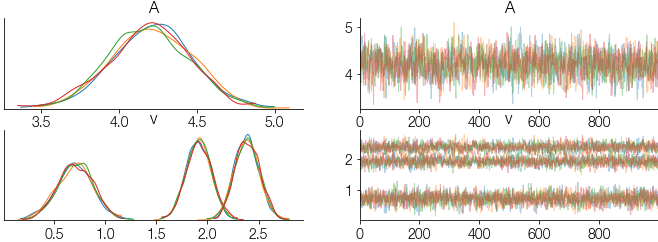

In [6]:
h = pm.traceplot(trace)

## Get estimates of model parameters

This can be done in different ways, for example by calculating the mean over all samples or finding the maximum a posteriori parameters. Here, we take the mean for simplicity. 

These parameter estimates should be relatively close to the ones used to generate the data. Note, however, that estimation will never be perfect, and estimation accuracy depends on the number of data points we're fitting. For example, estimating the speed of the slowest accumulator is harder because we have fewer examples of that response in our simulated dataset.

In [7]:
fixed = {'s': 1, 'tau': 0, 'b': 8}
group_vars = ['A', 'v']
param, subj_param = model.post_param(trace, fixed, group_vars)
param

{'s': 1,
 'tau': 0,
 'b': 8,
 'A': 4.202091548156978,
 'v': array([0.70656379, 1.915464  , 2.38729165])}

## Generate data from fitted model

Now that we have parameter estimates, we can generate new data to see what the fit looks like compared to the original (simulated) data. A simple way to assess the fit is by plotting the relative frequency of reaction time as a function of each response option.

In [8]:
sim = lba_model.gen(test_type, param, nrep=1)

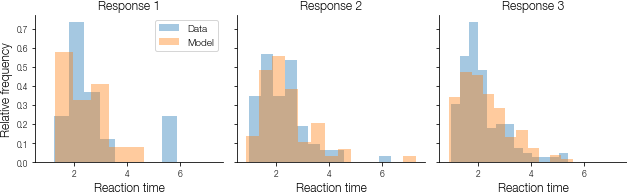

In [9]:
import psireact.plot as prp
g = prp.plot_fit(df, sim)